Importing the Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Problem Statement
Company XY introduced solar panels and accompanying batteries to make them self, less dependent on the main grid and therefore reduce their overall energy dependance and CO2 emissions. First phase of the project was successfully completed with installation of solar panels and accompanying batteries. The goal of the second phase is to analyze their consumption and try to reduce the usage of the main grid electricity to zero by using ML for prediction of next possible window where electricity from main grid will be needed. Current analysis has shown that the consumption of energy from main grid is still present and therefore the ML should be deployed to make predictions when the next possible usage from the main grid will take place so that the energy management team can put some measurements in place to prohibit such usage. For example, energy consumption should be reduced during this time to overcome the upcoming need for electricity from main grid.

nicht ELWOG  = Consumption from battery
Energie-Graz_Lf_ERZ = Consumption from mein Grid




In [79]:
import os
import pandas as pd

rootDir = 'Energiedaten/'

# The columns you're interested in
columns = ['Energie-Erzeuger', 'Von', 'Bis', 'Kwh']

grid_dataframes = []
bat_dataframes = []

for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        if "EV_AT0081000801000000000000000307612" in fname:
            df_grid = pd.read_csv(os.path.join(dirName, fname), delimiter=";")
            new_columns = ["KA", "Energie-Erzeuger", "Von", "Bis", "Kwh"]

            df_grid.columns = new_columns
            df_grid = df_grid.reset_index(drop=True)
            df_grid = df_grid.drop("KA", axis=1)

            df_grid['Kwh'] = df_grid['Kwh'].str.replace(',', '.').astype(float)

            df_grid['Von'] = pd.to_datetime(df_grid['Von'], format="%d.%m.%Y %H:%M")
            df_grid['Bis'] = pd.to_datetime(df_grid['Bis'], format="%d.%m.%Y %H:%M")

            #df_grid.set_index('Von', inplace=True)

            grid_data = df_grid[df_grid['Energie-Erzeuger'] == 'Energie-Graz_Lf_ERZ']
            grid_dataframes.append(df_grid)
        elif "EV_AT0081000801000000000000000310972" in fname:
            df_bat = pd.read_csv(os.path.join(dirName, fname), delimiter=";")

            new_columns = ["KA", "Nicht ELWOG", "Von", "Bis", "Kwh"]

            df_bat.columns = new_columns
            df_bat = df_bat.reset_index(drop=True)
            df_bat = df_bat.drop("KA", axis=1)

            df_bat['Kwh'] = df_bat['Kwh'].str.replace(',', '.').astype(float)

            df_bat['Von'] = pd.to_datetime(df_bat['Von'], format="%d.%m.%Y %H:%M")
            df_bat['Bis'] = pd.to_datetime(df_bat['Bis'], format="%d.%m.%Y %H:%M")
            
            bat_dataframes.append(df_bat)

df_grid = pd.concat(grid_dataframes, ignore_index=True)
df_bat = pd.concat(bat_dataframes, ignore_index=True)

# Merge the dataframes on 'Von'
df = df_bat.merge(df_grid, how='inner', on='Von', suffixes=('_battery', '_grid'))

# Select the required columns and rename them
df = df[['Von', 'Bis_battery', 'Kwh_battery', 'Kwh_grid']]
df.columns = ['von', 'bis', 'battery', 'grid']


In [80]:
# Assuming main_df is your main DataFrame
# Load the holidays data
holidays_df = pd.read_csv('Feiertage/holidays.csv')

# Convert the 'startDate' and 'endDate' to datetime format
holidays_df['startDate'] = pd.to_datetime(holidays_df['startDate'], format='%Y-%m-%d')
holidays_df['endDate'] = pd.to_datetime(holidays_df['endDate'], format='%Y-%m-%d')

# Initialize a new column 'holiday' in your main DataFrame with 0
df['holiday'] = 0

# Iterate over the holidays DataFrame
for i, row in holidays_df.iterrows():
    # Set 'holiday' to 1 where the date is in the holiday date range
    df.loc[(df['von'] >= row['startDate']) & (df['von'] <= row['endDate']), 'holiday'] = 1


In [42]:
df

,von,bis,battery,grid,holiday
0,2022-11-01 00:15:00,2022-11-01 00:30:00,1.83000,0.0,0
1,2022-11-01 00:30:00,2022-11-01 00:45:00,1.69125,0.0,0
2,2022-11-01 00:45:00,2022-11-01 01:00:00,1.64375,0.0,0
3,2022-11-01 01:00:00,2022-11-01 01:15:00,1.78375,0.0,0
4,2022-11-01 01:15:00,2022-11-01 01:30:00,1.57625,0.0,0
...,...,...,...,...,...
29177,2023-02-28 22:45:00,2023-02-28 23:00:00,1.41125,0.0,0
29178,2023-02-28 23:00:00,2023-02-28 23:15:00,1.39375,0.0,0
29179,2023-02-28 23:15:00,2023-02-28 23:30:00,1.48250,0.0,0
29180,2023-02-28 23:30:00,2023-02-28 23:45:00,1.31875,0.0,0


## Data Import
Import the data from energydata file

ValueError: Length mismatch: Expected axis has 4 elements, new values have 5 elements

In [99]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Normalizing the features
battery_scaler = MinMaxScaler(feature_range=(0, 1))
grid_scaler = MinMaxScaler(feature_range=(0, 1))

df['battery_scaled'] = battery_scaler.fit_transform(np.array(df['battery']).reshape(-1,1))
df['grid_scaled'] = grid_scaler.fit_transform(np.array(df['grid']).reshape(-1,1))

scaled_data = np.hstack((df['battery_scaled'].values.reshape(-1,1), df['grid_scaled'].values.reshape(-1,1)))


# Create sequences of 3 previous time steps (t-2, t-1, t) to predict the next time step (t+1)
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 50
X, y = create_sequences(scaled_data, seq_length)

# Reshape y for later compatibility with a keras method
y = y[:,1]

# Split the data into training (80%) and test sets (20%)
# We dont use the train_test_split because we want to preserve the temporal order of the data because -> timeseries
split = int(0.8 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict_transformed = grid_scaler.inverse_transform(train_predict)
test_predict_transformed = grid_scaler.inverse_transform(test_predict)





Epoch 1/50
729/729 - 13s - loss: 0.0030 - 13s/epoch - 18ms/step
Epoch 2/50
729/729 - 12s - loss: 0.0021 - 12s/epoch - 16ms/step
Epoch 3/50
729/729 - 12s - loss: 0.0020 - 12s/epoch - 16ms/step
Epoch 4/50
729/729 - 12s - loss: 0.0020 - 12s/epoch - 16ms/step
Epoch 5/50
729/729 - 12s - loss: 0.0020 - 12s/epoch - 16ms/step
Epoch 6/50
729/729 - 12s - loss: 0.0019 - 12s/epoch - 16ms/step
Epoch 7/50
729/729 - 13s - loss: 0.0019 - 13s/epoch - 17ms/step
Epoch 8/50
729/729 - 12s - loss: 0.0019 - 12s/epoch - 16ms/step
Epoch 9/50
729/729 - 12s - loss: 0.0019 - 12s/epoch - 16ms/step
Epoch 10/50
729/729 - 12s - loss: 0.0019 - 12s/epoch - 16ms/step
Epoch 11/50
729/729 - 12s - loss: 0.0019 - 12s/epoch - 16ms/step
Epoch 12/50
729/729 - 12s - loss: 0.0018 - 12s/epoch - 16ms/step
Epoch 13/50
729/729 - 12s - loss: 0.0018 - 12s/epoch - 16ms/step
Epoch 14/50
729/729 - 11s - loss: 0.0019 - 11s/epoch - 16ms/step
Epoch 15/50
729/729 - 12s - loss: 0.0018 - 12s/epoch - 17ms/step
Epoch 16/50
729/729 - 11s - loss: 

In [81]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Normalizing the features
battery_scaler = MinMaxScaler(feature_range=(0, 1))
grid_scaler = MinMaxScaler(feature_range=(0, 1))
#holiday_scaler = MinMaxScaler(feature_range=(0, 1))  # scaler for holiday

df['battery_scaled'] = battery_scaler.fit_transform(np.array(df['battery']).reshape(-1,1))
df['grid_scaled'] = grid_scaler.fit_transform(np.array(df['grid']).reshape(-1,1))
#df['holiday_scaled'] = holiday_scaler.fit_transform(np.array(df['holiday']).reshape(-1,1))  # scale holiday

scaled_data = np.hstack((df['battery_scaled'].values.reshape(-1,1), df['grid_scaled'].values.reshape(-1,1), df['holiday'].values.reshape(-1,1)))  # add holiday to the data

# Create sequences of 3 previous time steps (t-2, t-1, t) to predict the next time step (t+1)
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 50
X, y = create_sequences(scaled_data, seq_length)

# Reshape y for later compatibility with a keras method
y = y[:,1]

# Split the data into training (80%) and test sets (20%)
# We dont use the train_test_split because we want to preserve the temporal order of the data because -> timeseries
split = int(0.8 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict_transformed = grid_scaler.inverse_transform(train_predict)
test_predict_transformed = grid_scaler.inverse_transform(test_predict)


Epoch 1/50
730/730 - 3s - loss: 0.0030 - 3s/epoch - 4ms/step
Epoch 2/50
730/730 - 2s - loss: 0.0022 - 2s/epoch - 3ms/step
Epoch 3/50
730/730 - 2s - loss: 0.0021 - 2s/epoch - 3ms/step
Epoch 4/50
730/730 - 2s - loss: 0.0021 - 2s/epoch - 2ms/step
Epoch 5/50
730/730 - 2s - loss: 0.0021 - 2s/epoch - 2ms/step
Epoch 6/50
730/730 - 2s - loss: 0.0021 - 2s/epoch - 2ms/step
Epoch 7/50
730/730 - 2s - loss: 0.0021 - 2s/epoch - 2ms/step
Epoch 8/50
730/730 - 2s - loss: 0.0021 - 2s/epoch - 3ms/step
Epoch 9/50
730/730 - 3s - loss: 0.0021 - 3s/epoch - 4ms/step
Epoch 10/50
730/730 - 2s - loss: 0.0020 - 2s/epoch - 3ms/step
Epoch 11/50
730/730 - 2s - loss: 0.0020 - 2s/epoch - 2ms/step
Epoch 12/50
730/730 - 2s - loss: 0.0020 - 2s/epoch - 3ms/step
Epoch 13/50
730/730 - 3s - loss: 0.0020 - 3s/epoch - 4ms/step
Epoch 14/50
730/730 - 2s - loss: 0.0020 - 2s/epoch - 3ms/step
Epoch 15/50
730/730 - 2s - loss: 0.0020 - 2s/epoch - 3ms/step
Epoch 16/50
730/730 - 2s - loss: 0.0020 - 2s/epoch - 2ms/step
Epoch 17/50
730/7

Train Score: 0.04349 RMSE
Test Score: 0.02688 RMSE


In [73]:
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train, train_predict[:,0]))
print('Train Score: %.5f RMSE' % (train_score))

test_score = math.sqrt(mean_squared_error(y_test, test_predict[:,0]))
print('Test Score: %.5f RMSE' % (test_score))


Train Score: 0.04376 RMSE
Test Score: 0.02744 RMSE


In [71]:
from sklearn.metrics import mean_squared_error
import math
# MIT HOLIDAY
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train, train_predict[:,0]))
print('Train Score: %.5f RMSE' % (train_score))

test_score = math.sqrt(mean_squared_error(y_test, test_predict[:,0]))
print('Test Score: %.5f RMSE' % (test_score))


Train Score: 0.04377 RMSE
Test Score: 0.02669 RMSE


In [94]:
print(df.loc[df['holiday'] == 1, 'grid'].mean())

print(df.loc[df['holiday'] == 0, 'grid'].mean())

print(df.loc[df['holiday'] == 1, 'battery'].mean())

print(df.loc[df['holiday'] == 0, 'battery'].mean())


0.02659545454545454
0.030137385587679793
1.5153992424242428
2.0263317230858635


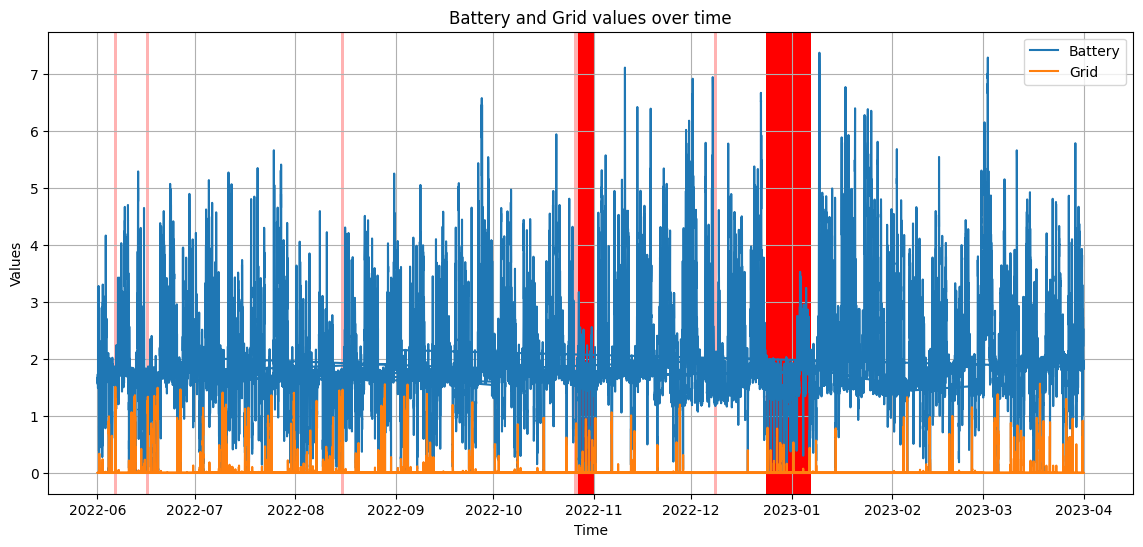

In [98]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))

# plot battery
plt.plot(df['von'], df['battery'], label='Battery')

# plot grid
plt.plot(df['von'], df['grid'], label='Grid')

# highlighting the holiday days
holiday_days = df[df['holiday']==1]['von']
for day in holiday_days:
    plt.axvspan(day, day+pd.DateOffset(days=1), facecolor='r', alpha=0.3)

plt.title('Battery and Grid values over time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [92]:
df.head()

,von,bis,battery,grid,holiday,battery_scaled,grid_scaled
0,2022-11-01 00:15:00,2022-11-01 00:30:00,1.83000,0.0,0,0.248346,0.0
1,2022-11-01 00:30:00,2022-11-01 00:45:00,1.69125,0.0,0,0.229517,0.0
2,2022-11-01 00:45:00,2022-11-01 01:00:00,1.64375,0.0,0,0.223070,0.0
3,2022-11-01 01:00:00,2022-11-01 01:15:00,1.78375,0.0,0,0.242070,0.0
4,2022-11-01 01:15:00,2022-11-01 01:30:00,1.57625,0.0,0,0.213910,0.0


## Data Analysis
Initial decision which Models/Algorithms arr going to br used as potential candidates for the final model. Elaborate why these models

In [64]:
#LSTM



## Data Preprocessing
Here you should prepare data accordingly

In [24]:
from sklearn.preprocessing import MinMaxScaler

grid_data_hourly = grid_data['Kwh'].resample('H').sum()

# Reshape data for scaling
data = np.array(grid_data_hourly).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

## Training and build Models
Use at least two different models. One from deep learning LSTM and one from classical ML (ensemble ML)

In [25]:
train_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - train_size

train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(20))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=150, batch_size=1, verbose=2)


Epoch 1/150
584/584 - 1s - loss: 0.0164 - 715ms/epoch - 1ms/step
Epoch 2/150
584/584 - 0s - loss: 0.0149 - 225ms/epoch - 386us/step
Epoch 3/150
584/584 - 0s - loss: 0.0116 - 217ms/epoch - 372us/step
Epoch 4/150
584/584 - 0s - loss: 0.0079 - 218ms/epoch - 374us/step
Epoch 5/150
584/584 - 0s - loss: 0.0058 - 219ms/epoch - 376us/step
Epoch 6/150
584/584 - 0s - loss: 0.0046 - 220ms/epoch - 376us/step
Epoch 7/150
584/584 - 0s - loss: 0.0039 - 217ms/epoch - 372us/step
Epoch 8/150
584/584 - 0s - loss: 0.0035 - 216ms/epoch - 370us/step
Epoch 9/150
584/584 - 0s - loss: 0.0033 - 218ms/epoch - 374us/step
Epoch 10/150
584/584 - 0s - loss: 0.0032 - 224ms/epoch - 383us/step
Epoch 11/150
584/584 - 0s - loss: 0.0030 - 217ms/epoch - 372us/step
Epoch 12/150
584/584 - 0s - loss: 0.0030 - 218ms/epoch - 373us/step
Epoch 13/150
584/584 - 0s - loss: 0.0029 - 217ms/epoch - 372us/step
Epoch 14/150
584/584 - 0s - loss: 0.0028 - 218ms/epoch - 373us/step
Epoch 15/150
584/584 - 0s - loss: 0.0028 - 217ms/epoch - 37

Epoch 122/150
584/584 - 0s - loss: 0.0023 - 217ms/epoch - 372us/step
Epoch 123/150
584/584 - 0s - loss: 0.0024 - 216ms/epoch - 370us/step
Epoch 124/150
584/584 - 0s - loss: 0.0023 - 216ms/epoch - 370us/step
Epoch 125/150
584/584 - 0s - loss: 0.0023 - 224ms/epoch - 383us/step
Epoch 126/150
584/584 - 0s - loss: 0.0023 - 219ms/epoch - 374us/step
Epoch 127/150
584/584 - 0s - loss: 0.0023 - 217ms/epoch - 371us/step
Epoch 128/150
584/584 - 0s - loss: 0.0023 - 219ms/epoch - 376us/step
Epoch 129/150
584/584 - 0s - loss: 0.0023 - 231ms/epoch - 396us/step
Epoch 130/150
584/584 - 0s - loss: 0.0023 - 219ms/epoch - 376us/step
Epoch 131/150
584/584 - 0s - loss: 0.0023 - 217ms/epoch - 372us/step
Epoch 132/150
584/584 - 0s - loss: 0.0023 - 220ms/epoch - 377us/step
Epoch 133/150
584/584 - 0s - loss: 0.0023 - 229ms/epoch - 391us/step
Epoch 134/150
584/584 - 0s - loss: 0.0023 - 219ms/epoch - 376us/step
Epoch 135/150
584/584 - 0s - loss: 0.0023 - 217ms/epoch - 371us/step
Epoch 136/150
584/584 - 0s - loss:

## Evaluation and selection of the model
Here multiple models should be evaluated and finaly selected. 


In [27]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


import math
from sklearn.metrics import mean_squared_error

train_score = math.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))

test_score = math.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))


5/5 [==============================] - 0s 572us/step
Train Score: 0.26 RMSE
Test Score: 0.44 RMSE


## Conclusion and reflection
Please reflect on the project and provide the conclusion

## Test the model with some data
Create your own new data representing wine and test the model

In [36]:
import pandas as pdhf
Feiertage/

SyntaxError: invalid syntax (1408671372.py, line 2)

ImportError: cannot import name 'urlopen' from 'requests' (/home/codespace/.local/lib/python3.10/site-packages/requests/__init__.py)